In [65]:
import random
import json
import pickle
import numpy as np
import tensorflow as tf
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
import difflib

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abcd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abcd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **ChatBot Model Training Using Feedforward Neural Network**

In [68]:
with open('intents.json') as file:
    intents = json.load(file)

lemmatizer = WordNetLemmatizer()

words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']

for intent in intents['intents']:
    for pattern in intent['patterns']:
        word_list = nltk.word_tokenize(pattern)
        words.extend(word_list)
        documents.append((word_list, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

with open('words.pkl', 'wb') as f:
    pickle.dump(words, f)
with open('classes.pkl', 'wb') as f:
    pickle.dump(classes, f)

training = []
output_empty = [0] * len(classes)

for document in documents:
    bag = []
    word_patterns = document[0]
    word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns]
    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)

    output_row = list(output_empty)
    output_row[classes.index(document[1])] = 1
    training.append(bag + output_row)

random.shuffle(training)
training = np.array(training, dtype=np.float32)

trainX = training[:, :len(words)]
trainY = training[:, len(words):]

class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=[doc[1] for doc in documents])
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(len(trainX[0]),), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(trainY[0]), activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model.fit(trainX, trainY, epochs=500, batch_size=8, class_weight=class_weights, verbose=1, callbacks=[early_stopping])
model.save('chatbot_model.h5')
with open('training_data.pkl', 'wb') as f:
    pickle.dump(training, f)
print('Training complete and model saved!')

Epoch 1/500


C:\Users\abcd\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0812 - loss: 2.6255
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0862 - loss: 2.6699 
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1323 - loss: 2.3910
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1017 - loss: 2.5859 
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1201 - loss: 2.5744 
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1723 - loss: 2.2991 
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1593 - loss: 2.3503     
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1887 - loss: 2.2138 
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2298 - loss: 2.6073 
Epoch 10/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2747 - loss: 2.2836 
Epoch 11/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3078 - loss: 2.1646 
Epoch 12/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

Training complete and model saved!


# **Analysis of Chatbot Model**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Accuracy: 0.95

Classification Report:
                      precision    recall  f1-score   support

             anxiety       1.00      0.87      0.93        15
             bipolar       1.00      1.00      1.00        10
            confused       1.00      1.00      1.00         9
          depression       1.00      0.93      0.96        14
                fear       1.00      1.00      1.00         8
             goodbye       1.00      1.00      1.00         6
            greeting       1.00      1.00      1.00         8
   knowledge_anxiety       0.67      1.00      0.80         4
knowledge_depression       0.80      1.00      0.89         4
    knowledge_stress       0.57      1.00      0.73         4
personality disorder       1.00      1.00      1.00         4
              stress       1.00      0.82      0.90        17
            suicidal       1.00      1.00      1.00        10

            accuracy                           0.95  

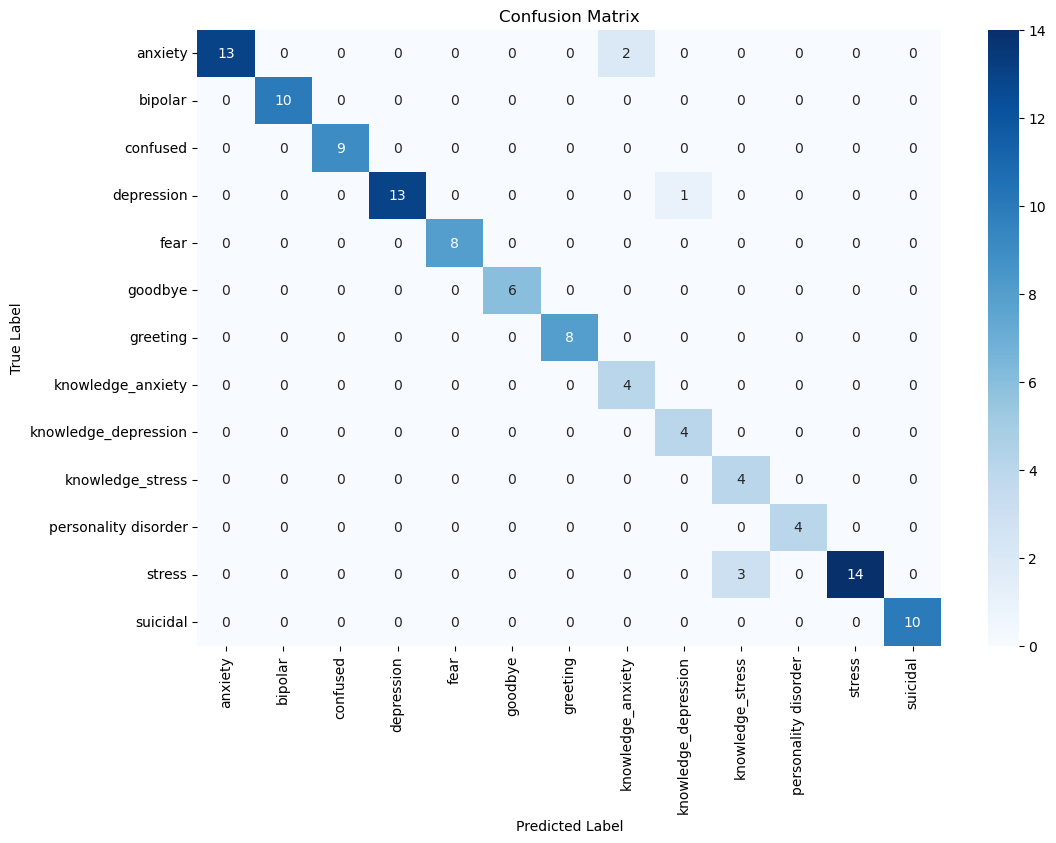

In [70]:
words = pickle.load(open('words.pkl', 'rb'))
classes = pickle.load(open('classes.pkl', 'rb'))
model = tf.keras.models.load_model('chatbot_model.h5')

training = pickle.load(open('training_data.pkl', 'rb'))  # Save training data during training

trainX = training[:, :len(words)]
trainY = training[:, len(words):]
y_pred = model.predict(trainX)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(trainY, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

report = classification_report(y_true, y_pred, target_names=classes)
print("\nClassification Report:")
print(report)

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# **Chatbot Responses**

In [84]:
lemmatizer = WordNetLemmatizer()
with open('intents.json') as file:
    intents = json.load(file)

words = pickle.load(open('words.pkl', 'rb'))
classes = pickle.load(open('classes.pkl', 'rb'))
model = load_model('chatbot_model.h5')

context = {}
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words
def bag_of_words(sentence):
    sentence_words = clean_up_sentence(sentence)
    bag = [0] * len(words)
    for w in sentence_words:
        for i, word in enumerate(words):
            if word == w:
                bag[i] = 1
    return np.array(bag)
def match_closest_pattern(user_input):
    all_patterns = [pattern for intent in intents['intents'] for pattern in intent['patterns']]
    closest_match = difflib.get_close_matches(user_input, all_patterns, n=1, cutoff=0.75)  # Increased cutoff for better accuracy
    return closest_match[0] if closest_match else user_input
def predict_class(sentence):
    sentence = match_closest_pattern(sentence)
    bow = bag_of_words(sentence)
    res = model.predict(np.array([bow]))[0]
    ERROR_THRESHOLD = 0.7  # Increased threshold for stricter matching
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)

    if len(results) > 1:
        return [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results[:2]]
    elif results:
        return [{'intent': classes[results[0][0]], 'probability': str(results[0][1])}]
    else:
        return [{'intent': 'fallback', 'probability': '1.0'}]
def get_response(intents_list, intents_json, user_id):
    tag = intents_list[0]['intent']

    if user_id not in context:
        context[user_id] = {'last_intent': None}

    previous_intent = context[user_id]['last_intent']
    context[user_id]['last_intent'] = tag

    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if i['tag'] == tag:
            response = random.choice(i['responses'])

            if previous_intent == 'stress' and tag == 'anxiety':
                response += " It seems like stress and anxiety are connected for you. Do you want to explore this further?"

            if previous_intent == 'anxiety' and tag == 'stress':
                response += " It's okay to feel this way. Would you like to try a relaxation exercise together?"

            if previous_intent == 'depression' and tag == 'suicidal':
                response += " It's important to talk to someone you trust about these feelings. You're not alone."

            if previous_intent == 'fear' and tag == 'anxiety':
                response += " Fear and anxiety are closely related. Would you like to explore this further?"

            if tag == 'yes' and previous_intent:
                response = "I'm glad you're open to talking more. What would you like to share?"

            if tag == 'fallback':
                if previous_intent:
                    response = "I'm not sure how to respond to that. Can you explain a bit more?"
                else:
                    response = "I'm not sure I understand. Could you clarify what you mean?"

            if tag.startswith('knowledge_'):
                response += " Let me know if you’d like to explore this more." 

            if tag == 'confused':
                response += " Take your time — I'm here if you need me."

            return response

    return "I'm sorry, I don't understand that."

print("🤖 Bot is running... Type 'exit' to quit")

user_id = 'user_1'
while True:
    message = input("You: ")
    if message.lower() == 'exit':
        print("🤖 Goodbye!")
        break

    ints = predict_class(message)
    res = get_response(ints, intents, user_id)
    print(f"🤖 {res}")

🤖 Bot is running... Type 'exit' to quit


You:  exit


🤖 Goodbye!
